In [1]:
import os

os.chdir('C:/Users/EunJin/Desktop/dacon/뱅크샐러드/train')
os.getcwd()

'C:\\Users\\EunJin\\Desktop\\dacon\\뱅크샐러드\\train'

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 500)

train = pd.read_csv('train.csv')
train.head(10)

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0
5,0,2016-12-19,13:36:39,30b1422f77,44,NaN,0,0
6,0,2016-12-19,14:00:23,6dd8dad5ab,146,NaN,0,0
7,0,2016-12-19,14:01:36,a4a425c5d2,6,NaN,0,0
8,0,2016-12-19,14:09:46,f213c011fe,306,NaN,0,0
9,0,2016-12-19,14:13:02,a185b7b11f,51,NaN,0,0


In [45]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns    
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
train = train.fillna(0)

In [4]:
train['timestamp'] = train.date+' '+train.time
train['timestamp'] = pd.to_datetime(train['timestamp'], format='%Y-%m-%d %H:%M:%S')

train['year'] = train['date'].apply(lambda x: int(x[:4]))
train['month'] = train['date'].apply(lambda x: int(x[5:7]))
train['day'] = train['date'].apply(lambda x: int(x[8:10]))

# hour/min/sec 변수 만들기

train['hour'] = train['time'].apply(lambda x: int(x[:2]))
train['min'] = train['time'].apply(lambda x: int(x[3:5]))
train['sec'] = train['time'].apply(lambda x: int(x[6:8]))

In [5]:
def seasonal(month) :
    if (month <= 5) & (month >= 3):
        return 0
    elif (month >= 6) & (month <= 8):
        return 1
    elif (month >= 9) & (month <= 11):
        return 2
    else :
        return 3
train['season'] = train['month'].apply(lambda x : seasonal(x))

In [6]:
def timezone(month) :
    if (month <= 5) & (month >= 1):
        return 0
    elif (month >= 6) & (month <= 10):
        return 1
    elif (month >= 11) & (month <= 14):
        return 2
    elif (month >= 15) & (month <= 17):
        return 3
    elif (month >= 18) & (month <= 20):
        return 4
    else :
        return 5
train['timezone'] = train['hour'].apply(lambda x : timezone(x))

# cluster 붙이기

In [14]:
cluster = pd.read_csv('cluster.csv')
cluster.head()

,Unnamed: 0,store_id,cluster
0,0,0,3
1,1,1,8
2,2,2,6
3,3,3,8
4,4,4,2


In [15]:
cluster = cluster[['store_id','cluster']]
cluster.head(1)

,store_id,cluster
0,0,3


In [16]:
train = pd.merge(train, cluster, how='left', on='store_id')

In [17]:
train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,timestamp,year,month,day,hour,min,sec,season,timezone,week_number,cluster
0,0,2016-12-14,18:05:31,d297bba73f,5,0.0,2,0,2016-12-14 18:05:31,2016,12,14,18,5,31,3,4,50,3
1,0,2016-12-14,18:05:54,d297bba73f,-5,0.0,2,0,2016-12-14 18:05:54,2016,12,14,18,5,54,3,4,50,3
2,0,2016-12-19,12:42:31,0880849c05,144,0.0,0,0,2016-12-19 12:42:31,2016,12,19,12,42,31,3,2,51,3
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,0.0,0,0,2016-12-19 12:48:08,2016,12,19,12,48,8,3,2,51,3
4,0,2016-12-19,13:31:08,7ad237eed0,24,0.0,0,0,2016-12-19 13:31:08,2016,12,19,13,31,8,3,2,51,3


In [29]:
pd.DataFrame(train.groupby(['cluster'])['store_id'].nunique())

,store_id
cluster,
0,58
1,261
2,815
3,31
4,2
5,248
6,35
7,11
8,314


# 단골손님

In [7]:
#일주일 기준
train['week_number'] = train['timestamp'].dt.isocalendar().week

In [8]:
df_week = train.groupby(by=['store_id','year','week_number', 'card_id'], as_index=False).agg({'timestamp': pd.Series.count})
df_week.head()

,store_id,year,week_number,card_id,timestamp
0,0,2016,50,d297bba73f,2
1,0,2016,51,007b34fb85,1
2,0,2016,51,0104ea7256,2
3,0,2016,51,0130c98e0d,3
4,0,2016,51,01a9950cd0,1


In [10]:
df_week2 = df_week[df_week['timestamp']>=2].reset_index(drop=True)
df_week2.head()

,store_id,year,week_number,card_id,timestamp
0,0,2016,50,d297bba73f,2
1,0,2016,51,0104ea7256,2
2,0,2016,51,0130c98e0d,3
3,0,2016,51,03aa3afe7a,2
4,0,2016,51,047823e75e,2


In [11]:
df_week2_gb = df_week2.groupby(by=['store_id','year','week_number'], as_index=False).agg({'card_id': pd.Series.nunique})
df_week2_gb = df_week2_gb.rename(columns={'card_id': 'n_card_week2'})

In [12]:
temp = train.groupby(by=['store_id','year','week_number'], as_index=False).agg({'card_id': pd.Series.nunique})
temp = temp.rename(columns={'card_id': 'n_card_total'})

In [13]:
df_week2_gb = pd.merge(df_week2_gb, temp, how='right')
df_week2_gb['regular_percent'] = 100*df_week2_gb['n_card_week2']/df_week2_gb['n_card_total']
df_week2_gb.fillna(0, inplace=True)
df_week2_gb.head()

,store_id,year,week_number,n_card_week2,n_card_total,regular_percent
0,0,2016,50,1.0,1,100.000000
1,0,2016,51,175.0,657,26.636225
2,0,2016,52,119.0,486,24.485597
3,0,2017,1,146.0,561,26.024955
4,0,2017,2,150.0,607,24.711697


In [30]:
df_week2_gb = pd.merge(df_week2_gb, cluster, how='left', on='store_id')
df_week2_gb.head()

,store_id,year,week_number,n_card_week2,n_card_total,regular_percent,cluster
0,0,2016,50,1.0,1,100.000000,3
1,0,2016,51,175.0,657,26.636225,3
2,0,2016,52,119.0,486,24.485597,3
3,0,2017,1,146.0,561,26.024955,3
4,0,2017,2,150.0,607,24.711697,3


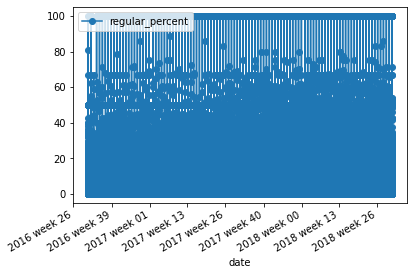

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Determine the date
df_week2_gb['date'] = pd.to_datetime(df_week2_gb.assign(day=1, month=1)[['year', 'month', 'day']])+pd.to_timedelta(df_week2_gb.week_number*7, unit='days')

# Plot
fig, ax = plt.subplots()
df_week2_gb.plot(x='date', y='regular_percent', marker='o', ax=ax)

# Format the x-ticks
myFmt = mdates.DateFormatter('%Y week %U')
ax.xaxis.set_major_formatter(myFmt)

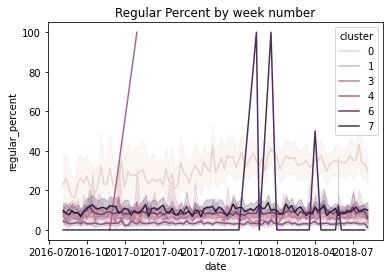

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns 

sns.lineplot(x='date', y='regular_percent', hue='cluster',data=df_week2_gb)
plt.title('Regular Percent by week number')
plt.show()

# result 불러오기

In [38]:
result = pd.read_csv('result.csv', index_col=0)

In [39]:
result.head(1)

,store_id,n_card,count,amount_q25,amount_q50,amount_q75,total_amount,count/n_card,total_amount/n_card,weekdays_count,weekend_count,weekdays_avg,weekend_avg,weekdays_sum,weekend_sum,weekdays_amount_avg,weekend_amount_avg,regular_percent,t01_05,t06_10,t11_14,t15_17,t18_20,t21_24,p01_05,p06_10,p11_14,p15_17,p18_20,p21_24,holiday_total_amount,n_holiday,n_days,total_amount/n_days,holiday_amount/n_holiday
0,0,12727,68773.0,26.0,51.0,96.0,5234611.0,5.403709,411.299678,48232.0,20541.0,9646.4,10270.5,3595164.0,1639447.0,719032.8,819723.5,26.890745,5989,7583,9400,11697,17568,16536,8.708359,11.026129,13.668155,17.008128,25.544909,24.04432,308833.0,31.0,591,8857.209814,9962.354839


In [40]:
result = pd.merge(result, cluster, how='left', on='store_id')

In [53]:
result['cluster'] = result['cluster'].astype('category')

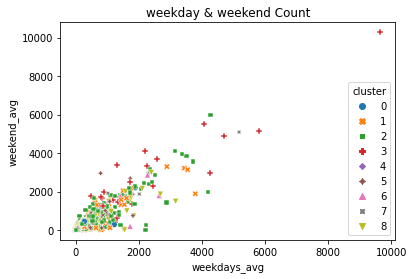

In [55]:
sns.scatterplot(x='weekdays_avg', y='weekend_avg', hue='cluster',style='cluster',data=result)
plt.title('weekday & weekend Count')
plt.show()

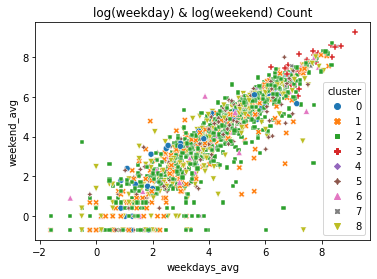

In [56]:
sns.scatterplot(x=np.log(result['weekdays_avg']), y=np.log(result['weekend_avg']), hue='cluster',style='cluster',data=result)
plt.title('log(weekday) & log(weekend) Count')
plt.show()

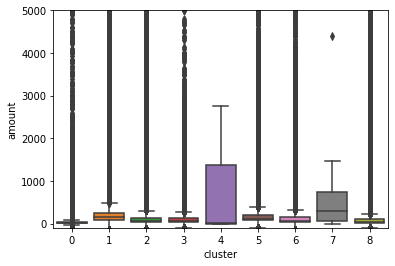

In [58]:
sns.boxplot(x="cluster", y="amount",  data=train)
plt.ylim(-100, 5000)
plt.show()

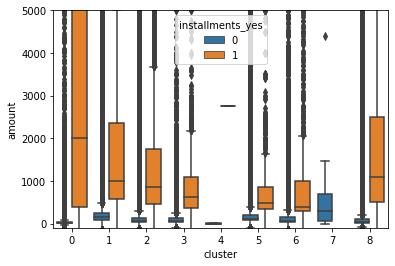

In [60]:
train['installments_yes'] = 0
train['installments_yes'][train['installments']>=1] = 1


sns.boxplot(x="cluster", y="amount", hue="installments_yes", data=train)
plt.ylim(-100, 5000)
plt.show()

In [61]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.DataFrame(result.groupby(['cluster'])['p01_05', 'p06_10', 'p11_14', 'p15_17', 'p18_20', 'p21_24'].mean())

,p01_05,p06_10,p11_14,p15_17,p18_20,p21_24
cluster,,,,,,
0,6.1421,32.4098,21.7170,14.9932,13.9365,10.8013
1,24.3261,0.8016,3.1038,3.2624,12.9626,55.5435
2,0.1700,2.9153,35.2233,23.5563,30.5044,7.6307
3,5.1750,4.8133,23.7263,17.4263,26.2102,22.6489
4,0.0000,0.0000,0.0000,50.0000,50.0000,0.0000
5,2.1774,0.4099,5.7002,7.3681,45.9356,38.4089
6,2.5914,10.3692,32.9138,20.6329,23.2903,10.2024
7,2.2727,12.7706,29.0909,29.1558,10.0433,16.6667
8,0.1531,8.7183,38.8709,37.4912,13.0842,1.6823


In [62]:
pd.DataFrame(result.groupby(['cluster'])['n_card',  'count/n_card',
       'weekdays_amount_avg', 'weekend_amount_avg', 'regular_percent','total_amount/n_days', 'holiday_amount/n_holiday'].mean())

,n_card,count/n_card,weekdays_amount_avg,weekend_amount_avg,regular_percent,total_amount/n_days,holiday_amount/n_holiday
cluster,,,,,,,
0,486.7414,84.0196,25446.7552,23074.3966,30.1956,9973.8480,496.5241
1,546.0115,15.7848,25251.2268,22465.7069,7.9402,2340.7652,848.3249
2,1080.6933,20.1937,35807.4756,35840.9890,7.0225,3165.7074,930.7167
3,1377.5484,203.5205,426032.7161,469404.3226,8.2568,36661.5055,1024.2880
4,1.0000,4417.0000,144417.8000,214555.7500,50.0000,1151200.5000,nan
5,1228.8226,13.0625,27514.4161,26522.1371,3.4987,2750.5028,757.6989
6,8645.1429,8.8905,57271.0857,55700.3000,9.0852,2372.5226,5409.3775
7,4.6364,2163.3731,133848.1636,156005.0909,9.5960,234329.0439,483.0000
8,306.6210,78.2514,26054.8631,22095.2866,9.4902,6655.7718,444.9772
